In [1]:

import torch
import torchvision.transforms as T
from PIL import Image

from featup.util import norm, unnorm

from hr_dv2.utils import *
import hr_dv2.transform as tr
from hr_dv2 import torch_pca

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_norm = True

In [3]:
path = "data/plant.png"
_img = Image.open(path)
_h, _w = _img.height, _img.width
t = tr.closest_crop(_h, _w, 14, True)

t = tr.get_input_transform(266, 266)

img_tensor, img = tr.load_image(path, t)
img_arr = np.array(img)
h, w, c = img_arr.shape


img_tensor.to(torch.float16)
img_tensor = img_tensor.to(device)
img_tensor = img_tensor.unsqueeze(0)

In [4]:
print(img_tensor.shape)

torch.Size([1, 3, 266, 266])


In [5]:
upsampler = torch.hub.load("mhamilton723/FeatUp", 'dinov2', use_norm=use_norm).to(device)
hr_feats = upsampler(img_tensor)
lr_feats = upsampler.model(img_tensor)
print(hr_feats.shape)

Using cache found in /home/ronan/.cache/torch/hub/mhamilton723_FeatUp_main
/home/ronan/Documents/uni_work/phd/hr_dv2/.venv/lib/python3.10/site-packages/featup/featurizers/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/Documents/uni_work/phd/hr_dv2/.venv/lib/python3.10/site-packages/featup/featurizers/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/Documents/uni_work/phd/hr_dv2/.venv/lib/python3.10/site-packages/featup/featurizers/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)"

OutOfMemoryError: CUDA out of memory. Tried to allocate 136.00 MiB (GPU 0; 3.81 GiB total capacity; 1.80 GiB already allocated; 124.81 MiB free; 1.88 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
img_tensor = img_tensor.to('cpu')

In [ ]:
feats_np = tr.to_numpy(hr_feats)

In [ ]:
print(feats_np.shape)

(384, 256, 256)


In [ ]:
feats_flat = tr.flatten(feats_np, 256, 256, 384)
pcaed = do_single_pca(feats_flat)

In [ ]:
rescaled = rescale_pca(pcaed)

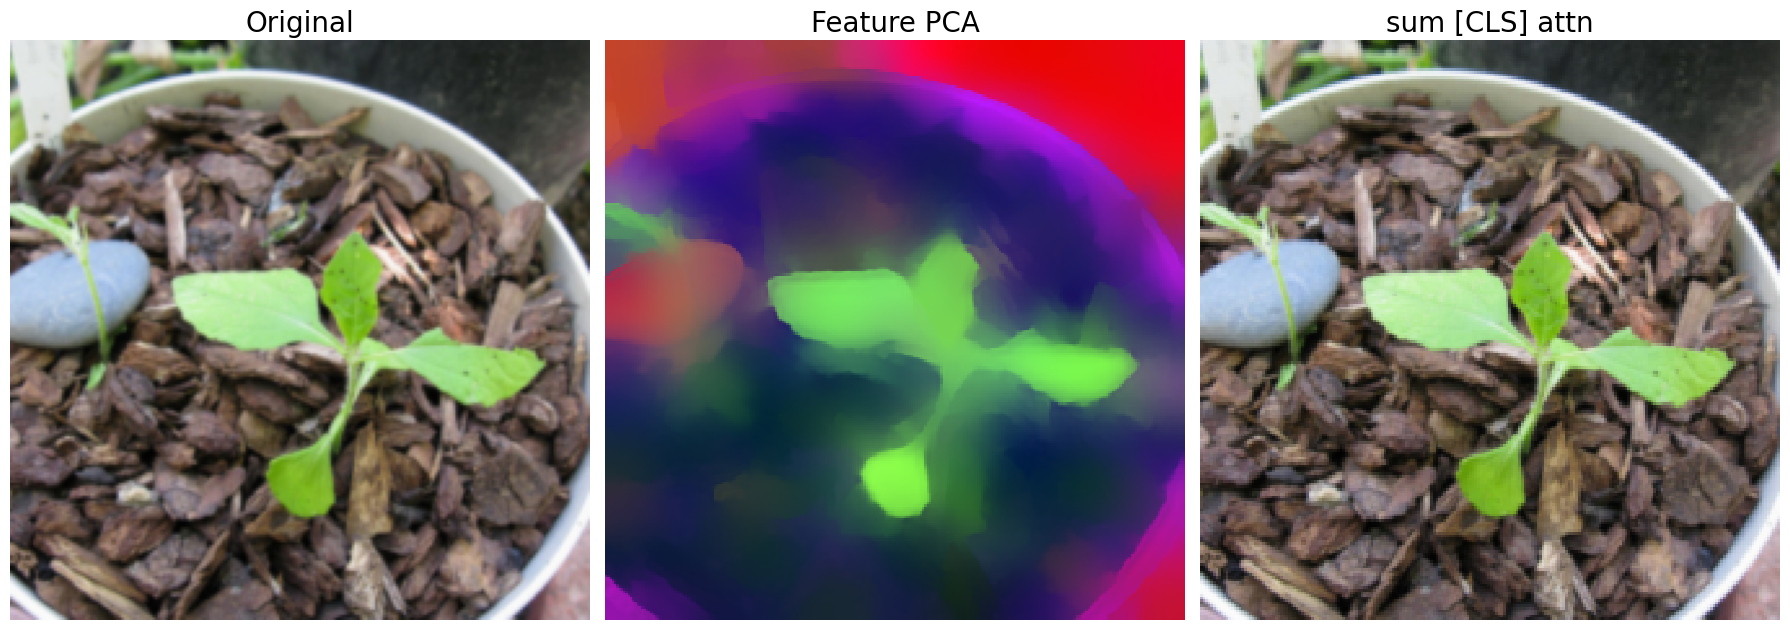

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(18, 8)

axs[0].imshow(img_arr)
axs[1].imshow(rescaled.reshape(256, 256, 3), interpolation='nearest')
axs[2].imshow(img_arr , interpolation='nearest')

titles = ["Original", "Feature PCA", "sum [CLS] attn"]
for i, ax in enumerate(axs):
    ax.set_axis_off()
    ax.set_title(titles[i], fontsize=20)
plt.tight_layout()